In [39]:
# Load with dill
import dill
with open('schuheinlagen_orakel.dill', 'rb') as f:
    ki_modell = dill.load(f)



In [40]:
help(ki_modell)

Help on SchuheinlagenOrakel in module __main__ object:

class SchuheinlagenOrakel(builtins.object)
 |  SchuheinlagenOrakel(model)
 |  
 |  Dies ist das Schuheinlagen Orakel. Das Orakel ist ein KI-System,
 |  das die Produktion von personalisierten Schuheinlagen unterstützt.
 |  Die einzige Methode, die das KI-System zur Verfügung stellt, ist die
 |  Prognose .predict(). Mehr Details: help(modell.predict)
 |  
 |  Beispiel:
 |  
 |  import pandas as pd 
 |  
 |  bauteile = pd.DataFrame({
 |      'Zellenform': [1, 1],
 |      'Zellengroesse': [3.0, 3.3],
 |      'Fuellgrad': [0.3, 0.38]
 |  })
 |  maximale_kraft = modell.predict(X)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model)
 |  
 |  predict(self, X)
 |      Prognostiziert die maximale Kraft, die von dem Bauteil aufgenommen werden kann.
 |      
 |      Argument X:
 |          Pandas DataFrame: Beschreibung der Eigenschaften des Bauteils.
 |      
 |          Die Spalten des Pandas DataFrames beinhalten 
 |          * '

In [41]:
import pandas as pd 

bauteil = pd.DataFrame({
    'Zellenform': [1],
    'Zellengroesse': [3.0],
    'Fuellgrad': [0.3]
})

bauteil.head()

,Zellenform,Zellengroesse,Fuellgrad
0,1,3.0,0.3


In [93]:
import numpy as np
np.random.seed(42) 

N = 100
zellenform = np.ones(N)
zellengroesse = 3.0 + np.random.normal(0, 0.1, N)
fuellgrad = 0.3 + np.random.normal(0, 0.1, N)

eingabedaten = pd.DataFrame({
    'Zellenform': zellenform,
    'Zellengroesse': zellengroesse,
    'Fuellgrad': fuellgrad
}) 

ausgabedaten = ki_modell.predict(eingabedaten)

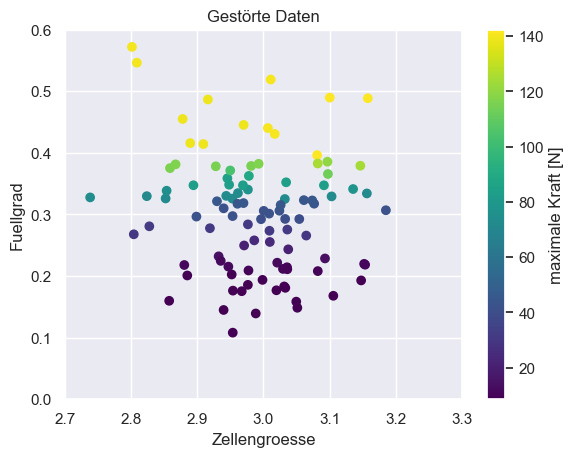

In [56]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots()
scatterplot = ax.scatter('Zellengroesse', 'Fuellgrad', data=eingabedaten, c=ausgabedaten, cmap='viridis')
ax.set_xlabel('Zellengroesse')
ax.set_ylabel('Fuellgrad')
ax.set_title('Gestörte Daten')
ax.set_xlim([2.7, 3.3])
ax.set_ylim([0.0, 0.6])

# Farbelegende
cbar = plt.colorbar(scatterplot)
cbar.set_label('maximale Kraft [N]')

In [94]:
import plotly.express as px 

fig = px.scatter( eingabedaten, x='Zellengroesse', y='Fuellgrad', color=ausgabedaten,
    title='Gestörte Daten um ausgewähltes Beispiel (3, 0.3)', labels={'color': 'maximale Kraft [N]'},
)
fig.update_xaxes(range=[2.7, 3.3])
fig.update_yaxes(range=[0.0, 0.6])

fig.show()

In [96]:
from sklearn.linear_model import LinearRegression

modell = LinearRegression()
modell.fit(eingabedaten, ausgabedaten)
modell.score(eingabedaten, ausgabedaten)

0.8767627285950327

In [97]:
modell.coef_

array([  0.        ,   9.4949024 , 457.30969469])

In [98]:
457.3 / 9.5

48.136842105263156

In [99]:
from scipy.spatial import distance

# Berechnung des euklidischen Abstands zwischen dem Referenzbeispiel und jeder variierten Instanz
referenz_beispiel = [1, 3.0, 0.3]
abstaende = eingabedaten.apply(lambda x: distance.euclidean(x, referenz_beispiel), axis=1)

# Gewichtung der Stichprobe: Je geringer der Abstand, desto höher das Gewicht
sigma = 0.1  # Einflussfaktor für die Gewichtung
gewichte = np.exp(- (abstaende ** 2) / (2 * sigma ** 2))

# Hinzufügen der Gewichte zur DataFrame
eingabedaten['Gewicht'] = gewichte
eingabedaten.head()

,Zellenform,Zellengroesse,Fuellgrad,Gewicht
0,1.0,3.049671,0.158463,0.324653
1,1.0,2.986174,0.257935,0.906622
2,1.0,3.064769,0.265729,0.764543
3,1.0,3.152303,0.219772,0.227266
4,1.0,2.976585,0.283871,0.960386


In [100]:
modell.fit(eingabedaten[['Zellenform', 'Zellengroesse', 'Fuellgrad']], ausgabedaten, sample_weight=eingabedaten['Gewicht'])

LinearRegression()

In [102]:
modell.score(eingabedaten[['Zellenform', 'Zellengroesse', 'Fuellgrad']], ausgabedaten)

0.8600306716992553

In [104]:
modell.coef_

array([0.00000000e+00, 3.46800483e-02, 5.12420033e+02])

In [ ]:
abstaende = ((eingabedaten['Zellengroesse'] - 3.0)**2 + (eingabedaten['Fuellgrad'] - 0.3)**2)**0.5
minimaler_abstand = np.min(abstaende)
maximaler_abstand = np.max(abstaende)

print(minimaler_abstand)
print(maximaler_abstand)

m = 1/(minimaler_abstand - maximaler_abstand)
print(m)
b = -m * maximaler_abstand
print(b)

gewichte = m * abstaende + b


0.005843288750318635
0.33689390741229847
-3.0206860933887962
1.0176507410677427
0     0.564548
1     0.883899
2     0.796304
3     0.497665
4     0.931765
        ...   
95    0.560504
96    0.736080
97    0.926138
98    1.000000
99    0.665198
Length: 100, dtype: float64


In [126]:
(0.3**2 + 0.3**2)**0.5

0.4242640687119285